# Insurance Prediction

Predicting the probability of a building having an insurance claim during a certain period of time. i.e predicting the probability of a building having at least one claim over the insured period of the building.

In [ ]:
# ! pip install catboost
# ! pip install xgboost
# ! pip install lightgbm
# ! pip install shap

In [2]:
# Importing the needed library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

plt.style.use('seaborn')
%matplotlib inline

In [3]:
# Loading the data
train = pd.read_csv('/content/drive/MyDrive/Datasets/data-science-nigeria-2019-challenge-1-insurance-prediction/train_data.csv')
test = pd.read_csv('/content/drive/MyDrive/Datasets/data-science-nigeria-2019-challenge-1-insurance-prediction/test_data.csv')
var_desc = pd.read_csv('/content/drive/MyDrive/Datasets/data-science-nigeria-2019-challenge-1-insurance-prediction/VariableDescription.csv')
samsub = pd.read_csv('/content/drive/MyDrive/Datasets/data-science-nigeria-2019-challenge-1-insurance-prediction/SampleSubmission.csv')

In [4]:
# description of the feature
var_desc

,Variable,Description
0,Customer Id,Identification number for the Policy holder
1,YearOfObservation,year of observation for the insured policy
2,Insured_Period,duration of insurance policy in Olusola Insura...
3,Residential,is the building a residential building or not
4,Building_Painted,"is the building painted or not (N-Painted, V-N..."
5,Building_Fenced,"is the building fence or not (N-Fenced, V-Not ..."
6,Garden,building has garden or not (V-has garden; O-no...
7,Settlement,Area where the building is located. (R- rural ...
8,Building Dimension,Size of the insured building in m2
9,Building_Type,"The type of building (Type 1, 2, 3, 4)"


In [ ]:
# the sample submission file
samsub.head()

,Customer Id,Claim
0,H0,1
1,H10000,1
2,H10001,1
3,H10002,1
4,H10003,1


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.2+ KB


In [ ]:
train.shape

(7160, 14)

## Exploratory Data Analysis

In [ ]:
#display the first five rows of the test data
test.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code
0,H11920,2013,1.000000,0,V,N,O,R,300.0,1,1960.0,3,3310
1,H11921,2016,0.997268,0,V,N,O,R,300.0,1,1960.0,3,3310
2,H9805,2013,0.369863,0,V,V,V,U,790.0,1,1960.0,.,3310
3,H7493,2014,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321
4,H7494,2016,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321


In [ ]:
#display the first five rows of the train data
train.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [6]:
#Renaming the columns
train.columns = ['customer_id', 'year_obs', 'insured_period', 'residential',
       'building_painted', 'building_fenced', 'garden', 'settlement',
       'building_dimension', 'building_type', 'date_of_occupancy',
       'win_num', 'geo_code', 'claim']

train.columns

Index(['customer_id', 'year_obs', 'insured_period', 'residential',
       'building_painted', 'building_fenced', 'garden', 'settlement',
       'building_dimension', 'building_type', 'date_of_occupancy', 'win_num',
       'geo_code', 'claim'],
      dtype='object')

In [7]:
#Renaming the columns
test.columns = ['customer_id', 'year_obs', 'insured_period', 'residential',
       'building_painted', 'building_fenced', 'garden', 'settlement',
       'building_dimension', 'building_type', 'date_of_occupancy',
       'win_num', 'geo_code']

test.columns

Index(['customer_id', 'year_obs', 'insured_period', 'residential',
       'building_painted', 'building_fenced', 'garden', 'settlement',
       'building_dimension', 'building_type', 'date_of_occupancy', 'win_num',
       'geo_code'],
      dtype='object')

In [8]:
#writing a function to plot two countplots
def countplot(first, second):
  fig, ax = plt.subplots(1, 2, figsize = [15,5])
  
  sns.countplot(x = train[first], ax = ax[0]).set_title(f"{first} distribution")
  sns.countplot(x = train[second], ax = ax[1]).set_title(f"{second} distribution")

  fig.show()

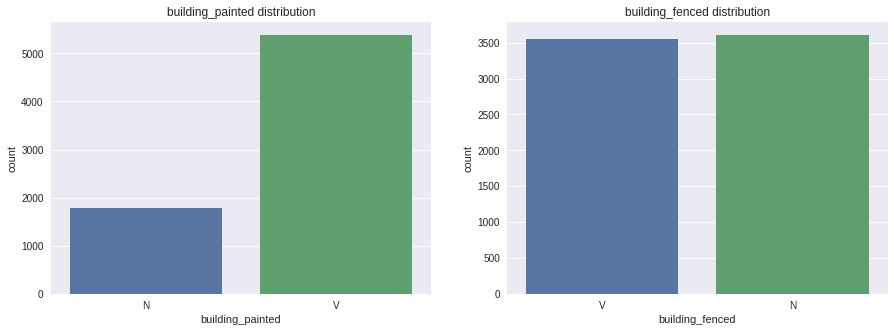

In [ ]:
countplot('building_painted', 'building_fenced')

In **building_painted** column, N-Painted, V-Not Painted

In **building_fenced** column, N-Fenced, V-Not Fenced

- Most of the builings were not painted
- There is only a slight different between the number of buildngs that were not fenced and those that were fenced with the highest being those that are fenced

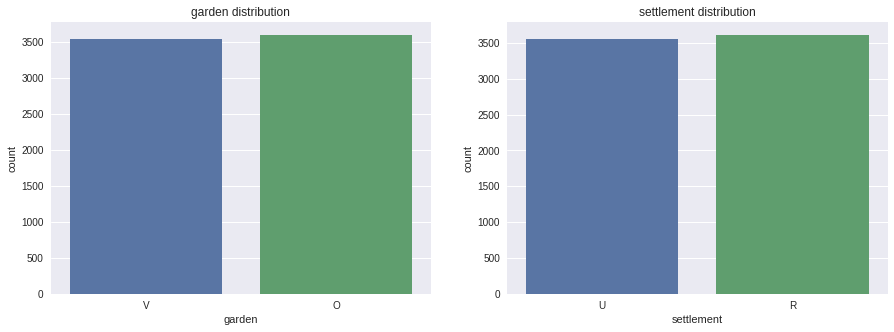

In [ ]:
countplot('garden', 'settlement')

In **garden** column, V-has garden, O-no garden

In **settlement** column, R-rural area, U- urban area

- There is only a slight different between the number of buildngs with garden and those without garden. Buildings with no garden is slightly higher than those with garden.

- There is only a slight different between the number of buildngs located in urban area and those in rural area. Number of buildings located in rural area is slightly higher than those in urban areas.
 
   *There is an observable correlation betwen these two columns*

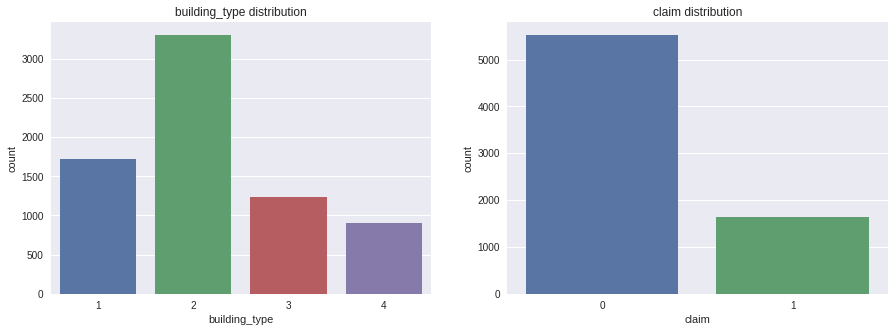

In [ ]:
countplot('building_type', 'claim')  

- Building type **2** has the highest frequency
- Most of the Buldings has no insurance claim

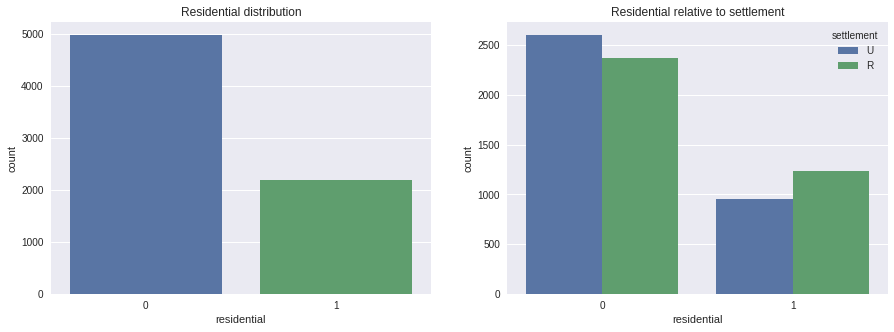

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = [15, 5])
sns.countplot(x = train.residential, ax = ax[0]).set_title('Residential distribution')
sns.countplot(x = train.residential, hue = train.settlement, ax = ax[1]).set_title('Residential relative to settlement')
plt.show()

- Most of the buildings are not residential
- Most of the buildings in urban areas are not residential while most of the building in rural area are residential. This could be due to the fact that no industry(or few) is located in rural areas. hence all buildings are residential unlike urban areas

In [9]:
def countplott(first, second, third):
  fig, ax = plt.subplots(1, 2, figsize = [15,5])
  
  sns.countplot(x = train[first], hue = train[second], ax = ax[0]).set_title(f"claim hued by {second}")
  sns.countplot(x = train[first], hue = train[third], ax = ax[1]).set_title(f"claim hued by {third}")

  fig.show()

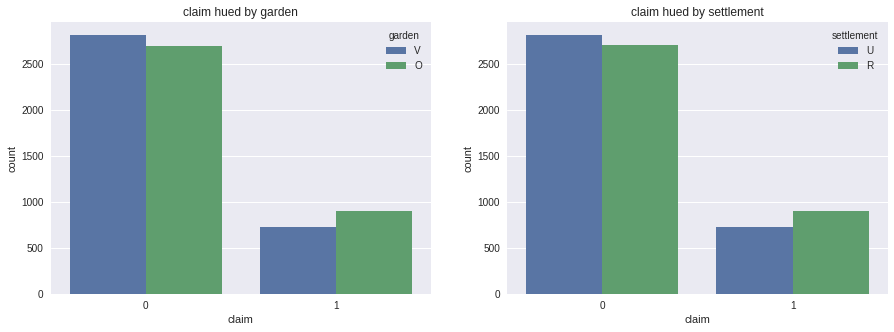

In [ ]:
countplott('claim', 'garden', 'settlement')

- Most of the houses with garden has no insurance claim while most of the garden without garden has insurance claim

- Most of the houses in Urban areas has no insurance claim while most of the houses in rural areas has insurance claim

   *The two two columns appear to display the same or similar information, one of them will be dropped in the modelling phase.*

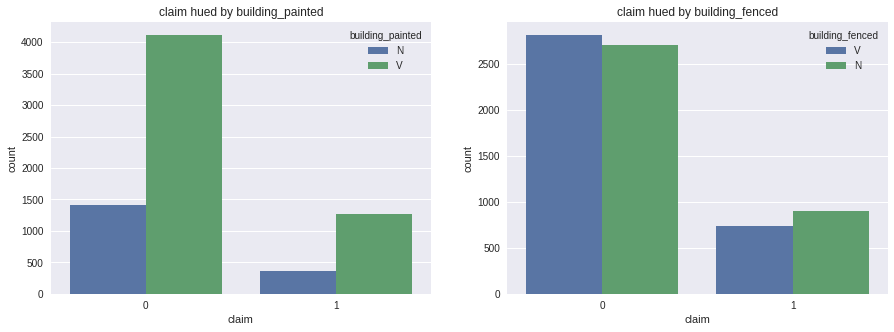

In [ ]:
countplott('claim', 'building_painted', 'building_fenced')

- Most of the building that were not painted didn't have insurance claim while most of the building that were painted has insurance claim

- Most of the fenced building were not insured while most of the non-fenced building were insured.

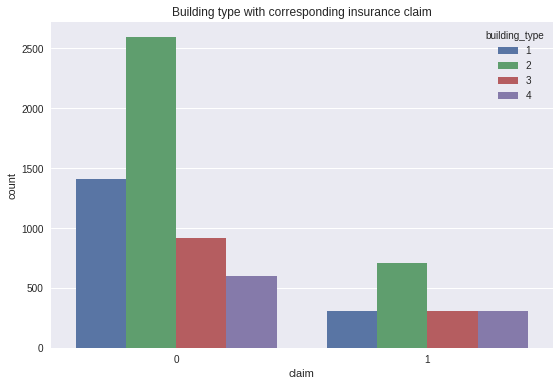

In [ ]:
plt.figure(figsize = (9,6))
sns.countplot(x = train['claim'],hue = train['building_type']).set_title("Building type with corresponding insurance claim")
plt.show()

Genrally, building type has the highest frequency, hence, it has the highest value for most insured and non insured building

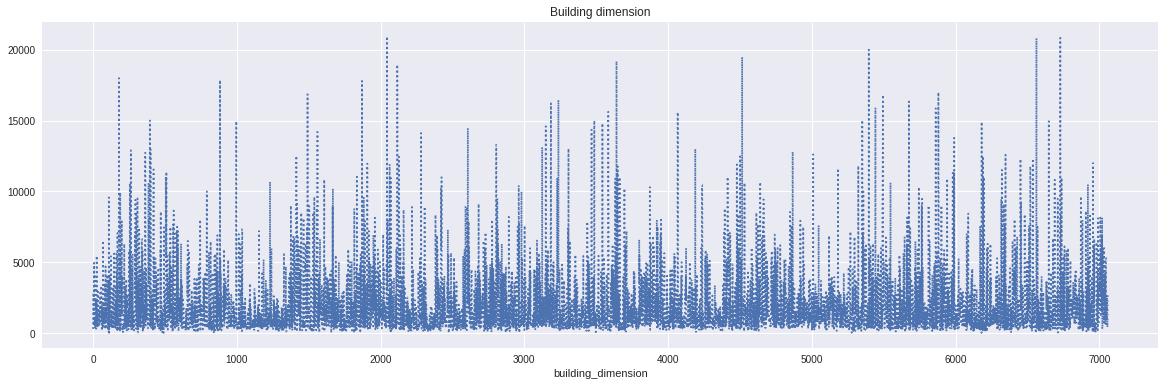

In [ ]:
plt.figure(figsize = (20, 6))
plt.plot(train['building_dimension'], linestyle = ':')
plt.title("Building dimension")
plt.xlabel("building_dimension")
plt.show()

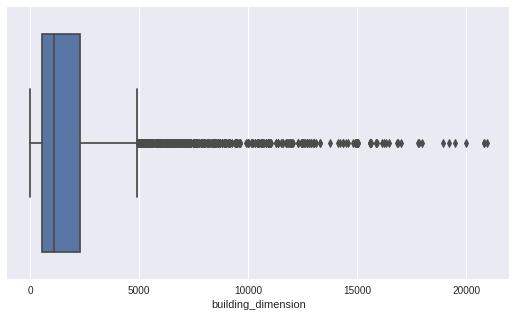

In [ ]:
plt.figure(figsize = (9, 5))
sns.boxplot(x = train['building_dimension'])
plt.show()

- The building dimension can be up to any size, hence the column will be left skewed.

## Data Preprocessing

In [38]:
data = train.append(test)

In [11]:
data.isnull().sum()

customer_id              0
year_obs                 0
insured_period           0
residential              0
building_painted         0
building_fenced          0
garden                  11
settlement               0
building_dimension     119
building_type            0
date_of_occupancy     1236
win_num                  0
geo_code               115
claim                 3069
dtype: int64

In [39]:
missing_col = ['building_dimension', 'date_of_occupancy']
for i in missing_col:
  data[i] = data[i].fillna(method = 'ffill')

In [40]:
#occupancy age is how long a particular person has been living in the house
data['occupancy_age'] = (data['year_obs'] - data['date_of_occupancy']).abs()

In [41]:
data = data.drop(['customer_id', 'garden', 'date_of_occupancy', 'year_obs', 'geo_code'], axis = 1)

In [42]:
data['win_num'].unique()

array(['   .', '4', '3', '2', '5', '>=10', '6', '7', '9', '8', '1'],
      dtype=object)

In [43]:
data['win_num'].mode()

0       .
dtype: object

In [ ]:
data['win_num'] = data['win_num'].replace(['   .', '>=10'], '10')

In [15]:
obj_col = [col for col in data.columns if data[col].dtype == 'object']
obj_col

['building_painted', 'building_fenced', 'settlement', 'win_num']

In [21]:
encoder = OrdinalEncoder()
for i in obj_col:
  data[[i]] = encoder.fit_transform(data[[i]])

data.head()

,insured_period,residential,building_painted,building_fenced,settlement,building_dimension,building_type,win_num,claim,occupancy_age
0,1.0,0,0.0,1.0,1.0,290.0,1,0.0,0.0,53.0
1,1.0,0,1.0,0.0,0.0,490.0,1,4.0,0.0,165.0
2,1.0,0,0.0,1.0,1.0,595.0,1,0.0,0.0,54.0
3,1.0,0,1.0,1.0,1.0,2840.0,1,0.0,0.0,53.0
4,1.0,0,1.0,0.0,0.0,680.0,1,3.0,0.0,214.0


## Modelling

In [24]:
train_df  = data[~data['claim'].isna()].reset_index(drop=True)
test_df = data[data['claim'].isna()].reset_index(drop=True)

In [26]:
train_df.shape, test_df.shape, train.shape, test.shape

((7160, 10), (3069, 10), (7160, 14), (3069, 13))

In [27]:
x = train_df.drop('claim', axis = 1)
y= train_df['claim']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

In [28]:
rf_base = RandomForestClassifier()
rf_base.fit(x_train, y_train)

RandomForestClassifier()

In [29]:
y_pred = rf_base.predict(x_test)

accuracy_score(y_pred, y_test)

0.7523277467411545

In [30]:
cat_base = CatBoostClassifier()
cat_base.fit(x_train, y_train)

Learning rate set to 0.020504
0:	learn: 0.6830477	total: 52.9ms	remaining: 52.8s
1:	learn: 0.6734576	total: 55.9ms	remaining: 27.9s
2:	learn: 0.6642733	total: 58.6ms	remaining: 19.5s
3:	learn: 0.6556074	total: 61.3ms	remaining: 15.3s
4:	learn: 0.6477138	total: 64.2ms	remaining: 12.8s
5:	learn: 0.6402556	total: 67ms	remaining: 11.1s
6:	learn: 0.6334116	total: 69.1ms	remaining: 9.8s
7:	learn: 0.6263289	total: 72ms	remaining: 8.93s
8:	learn: 0.6197983	total: 74.7ms	remaining: 8.23s
9:	learn: 0.6138230	total: 77.6ms	remaining: 7.68s
10:	learn: 0.6084262	total: 79.7ms	remaining: 7.17s
11:	learn: 0.6021127	total: 82.5ms	remaining: 6.79s
12:	learn: 0.5966926	total: 85.1ms	remaining: 6.46s
13:	learn: 0.5911437	total: 87.7ms	remaining: 6.18s
14:	learn: 0.5864639	total: 90.5ms	remaining: 5.94s
15:	learn: 0.5813782	total: 93.2ms	remaining: 5.73s
16:	learn: 0.5767782	total: 95.9ms	remaining: 5.55s
17:	learn: 0.5725000	total: 98.5ms	remaining: 5.37s
18:	learn: 0.5685583	total: 101ms	remaining: 5.21

In [31]:
y_pred = cat_base.predict(x_test)

accuracy_score(y_pred, y_test)

0.7746741154562383

In [32]:
xg_base = XGBClassifier()
xg_base.fit(x_train, y_train)

XGBClassifier()

In [33]:
lgbm_base = LGBMClassifier()
lgbm_base.fit(x_train, y_train)

LGBMClassifier()

In [34]:
y_pred = xg_base.predict(x_test)

accuracy_score(y_pred, y_test)

0.7821229050279329

In [35]:
y_pred = lgbm_base.predict(x_test)

accuracy_score(y_pred, y_test)

0.7723463687150838